### Import packages

In [1]:
import numpy as np
import pandas as pd

np.random.seed(1337)  # for reproducibility
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from dbn.tensorflow import SupervisedDBNRegression

### Defining Road and Year for dataset

In [2]:
# Read the dataset
ROAD = "Vicente Cruz"
YEAR = "2015"
EXT = ".csv"

### Defining Hyper parameters

In [3]:
RBM_EPOCHS = 5
DBN_EPOCHS = 150
RBM_LEARNING_RATE = 0.01
DBN_LEARNING_RATE = 0.01
HIDDEN_LAYER_STRUCT = [20, 50, 100]
ACTIVE_FUNC = 'relu'
BATCH_SIZE = 28

### Preparing PM1 and PM2 Output dataset for training

In [4]:
pm1_results = pd.read_csv("output/pm1_" + ROAD + "_" + YEAR + EXT, skipinitialspace=True)
pm2_results = pd.read_csv("output/pm2_" + ROAD + "_" + YEAR + EXT, skipinitialspace=True)

In [5]:
pm1_results.head()

,Actual,Predicted,dt
0,0.932784,0.782284,2015-07-22 03:45:00
1,0.940946,0.722699,2015-07-22 04:00:00
2,0.937501,0.714332,2015-07-22 04:15:00
3,0.916327,0.699462,2015-07-22 04:30:00
4,0.870975,0.678892,2015-07-22 04:45:00


In [6]:
pm1_results.tail()

,Actual,Predicted,dt
9772,0.307593,0.473410,2015-10-31 22:45:00
9773,0.289160,0.473065,2015-10-31 23:00:00
9774,0.284117,0.466739,2015-10-31 23:15:00
9775,0.304501,0.463504,2015-10-31 23:30:00
9776,0.360046,0.460537,2015-10-31 23:45:00


In [7]:
d = {'PM1-Output': pm1_results.Predicted, 'PM2-Output': pm2_results.Predicted}
fusion_dataset = pd.DataFrame(data=d)
fusion_dataset = np.array(fusion_dataset)
actual_dataset = pm1_results.Actual

In [8]:
# To-be Predicted variable
Y = actual_dataset
Y = Y.round(5)

# Training Data
X = fusion_dataset

# Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Data scaling
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)

### Training the Fusion Center

In [9]:
# Training
fc = SupervisedDBNRegression(hidden_layers_structure=HIDDEN_LAYER_STRUCT,
                                    learning_rate_rbm=RBM_LEARNING_RATE,
                                    learning_rate=DBN_LEARNING_RATE,
                                    n_epochs_rbm=RBM_EPOCHS,
                                    n_iter_backprop=DBN_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    activation_function=ACTIVE_FUNC)
fc.fit(X_train, Y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.079406
>> Epoch 2 finished 	RBM Reconstruction error 0.067581
>> Epoch 3 finished 	RBM Reconstruction error 0.058814
>> Epoch 4 finished 	RBM Reconstruction error 0.050440
>> Epoch 5 finished 	RBM Reconstruction error 0.044678
>> Epoch 1 finished 	RBM Reconstruction error 0.042794
>> Epoch 2 finished 	RBM Reconstruction error 0.040738
>> Epoch 3 finished 	RBM Reconstruction error 0.039997
>> Epoch 4 finished 	RBM Reconstruction error 0.038915
>> Epoch 5 finished 	RBM Reconstruction error 0.038008
>> Epoch 1 finished 	RBM Reconstruction error 0.004643
>> Epoch 2 finished 	RBM Reconstruction error 0.004197
>> Epoch 3 finished 	RBM Reconstruction error 0.004188
>> Epoch 4 finished 	RBM Reconstruction error 0.004191
>> Epoch 5 finished 	RBM Reconstruction error 0.004202
[END] Pre-training step
[START] Fine tuning step:
>> Epoch 0 finished 	ANN training loss 0.096497
>> Epoch 1 finished 	ANN training loss 0.096491
>>

>> Epoch 149 finished 	ANN training loss 0.057076
[END] Fine tuning step


SupervisedDBNRegression(batch_size=28, dropout_p=0, l2_regularization=1.0,
            learning_rate=0.01, n_iter_backprop=150, verbose=True)

In [10]:
#To check RBM Loss Errors:
rbm_error = fc.unsupervised_dbn.rbm_layers[0].rbm_loss_error
#To check DBN Loss Errors
dbn_error = fc.dbn_loss_error

### Testing the Fusion Center

In [11]:
# Test
X_test = min_max_scaler.transform(X_test)
Y_pred = fc.predict(X_test)

r2score = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae = mean_absolute_error(Y_test, Y_pred)
print('Done.\nR-squared: %.3f\nRMSE: %.3f \nMAE: %.3f' % (r2score, rmse, mae))

Done.
R-squared: 0.472
RMSE: 0.240 
MAE: 0.185


### Exporting predicted and actual results

In [12]:
startIndex = pm1_results.shape[0] - Y_pred.shape[0]
dt = pm1_results.dt[startIndex:,]
temp = []
for i in range(len(Y_pred)):
    temp.append(Y_pred[i][0])
d = {'Predicted': temp, 'Actual': Y_test, 'dt':dt}
fc_results = pd.DataFrame(data=d)

In [13]:
fc_results

,Actual,Predicted,dt
6550,0.08624,0.596327,2015-09-28 09:15:00
6551,0.08550,0.616125,2015-09-28 09:30:00
6552,0.08486,0.636755,2015-09-28 09:45:00
6553,0.08432,0.568511,2015-09-28 10:00:00
6554,0.08386,0.567075,2015-09-28 10:15:00
6555,0.08349,0.576795,2015-09-28 10:30:00
6556,0.08319,0.598414,2015-09-28 10:45:00
6557,0.08296,0.539590,2015-09-28 11:00:00
6558,0.08278,0.535509,2015-09-28 11:15:00
6559,0.08265,0.537247,2015-09-28 11:30:00


In [14]:
fc_results.to_csv("output/fc_" + ROAD  + "_" + YEAR + EXT, encoding='utf-8', index=False)

### Saving the model

In [15]:
# Save the model
fc.save('models/fc_' + ROAD + '_' + YEAR + '.pkl')

#### Visualize trend of loss of RBM and DBN Training

In [16]:
import matplotlib.pyplot as plt

In [17]:
fc_results.index = range(len(fc_results))

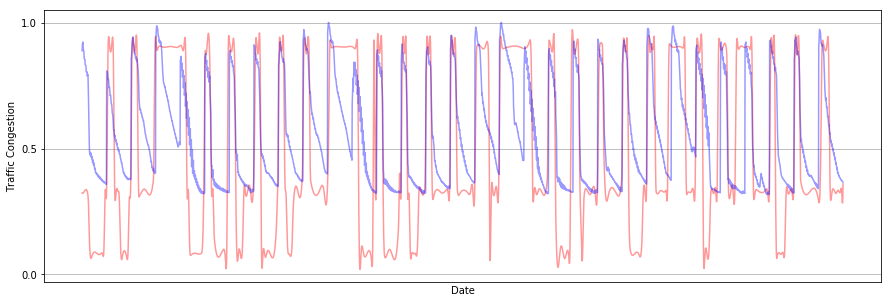

In [18]:
line1 = fc_results.Actual[251:]
line2 = fc_results.Predicted[251:]
plt.figure(figsize=(15, 5))

plt.grid()
plt.plot(line1, c='red', alpha=0.4)
plt.plot(line2, c='blue', alpha=0.4)
plt.xlabel("Date")
plt.ylabel("Traffic Congestion")
plt.yticks([0, 0.5, 1.0])
plt.xticks([])
plt.show()

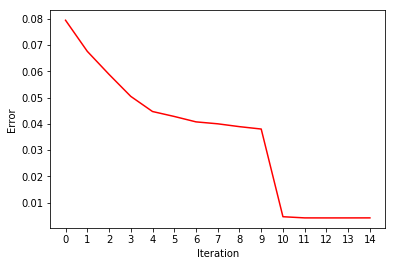

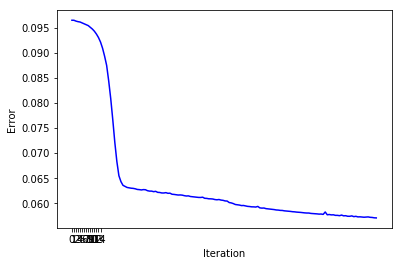

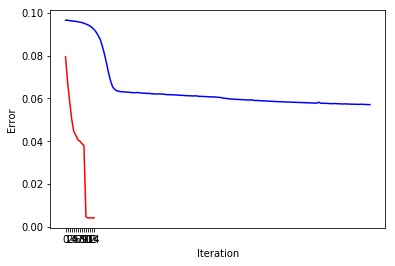

In [19]:
line1 = rbm_error
line2 = dbn_error
x = range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT))
plt.plot(range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT)), line1, c='red')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

plt.plot(range(DBN_EPOCHS), line2, c='blue')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

plt.plot(range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT)), line1, c='red')
plt.plot(range(DBN_EPOCHS), line2, c='blue')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()